# 3D interactive plotting with Plotly
_Daan - 26 June 2020_

I'm currently not working with Python code, as I'm grappling with MITgcm, so instead of a review, I have something to showcase. While working through some MITgcm examples, I was plotting some bathymetry files to better understand their geometry. Normally, we use stuff like `contourplot` or `pcolormesh` for this stuff, plotting depth through color. However, visually making sense of a third dimension through color alone may be hard (especially when bad colormaps are used, but we know that's a different story). Therefore I wanted to try out 3D plotting. Here I compare 3D plotting in `matplotlib` with the `plotly` graphing library (see https://plotly.com/python/). 

This is not intended as a tutorial, but more so as just a showcase, since I think most of us would be able to benefit from better 3D plotting.

In [33]:
# imports: make sure you have these installed
import numpy as np
import pandas as pd
import netCDF4
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Most of the stuff you'd want to do with plotly is achieved through `graph_objects`
import plotly.graph_objects as go

Let's first look at some topographical data. Plotly hosts an example file on Github, which we'll use as an example bathymetry file. We load data with Pandas. The result is a dataframe, but plotting works equally well with numpy or xarray data.

In [2]:
z_data = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv"
)

Let's start with a minimal example of how we would normally plot such data with `contourf` and `imshow`

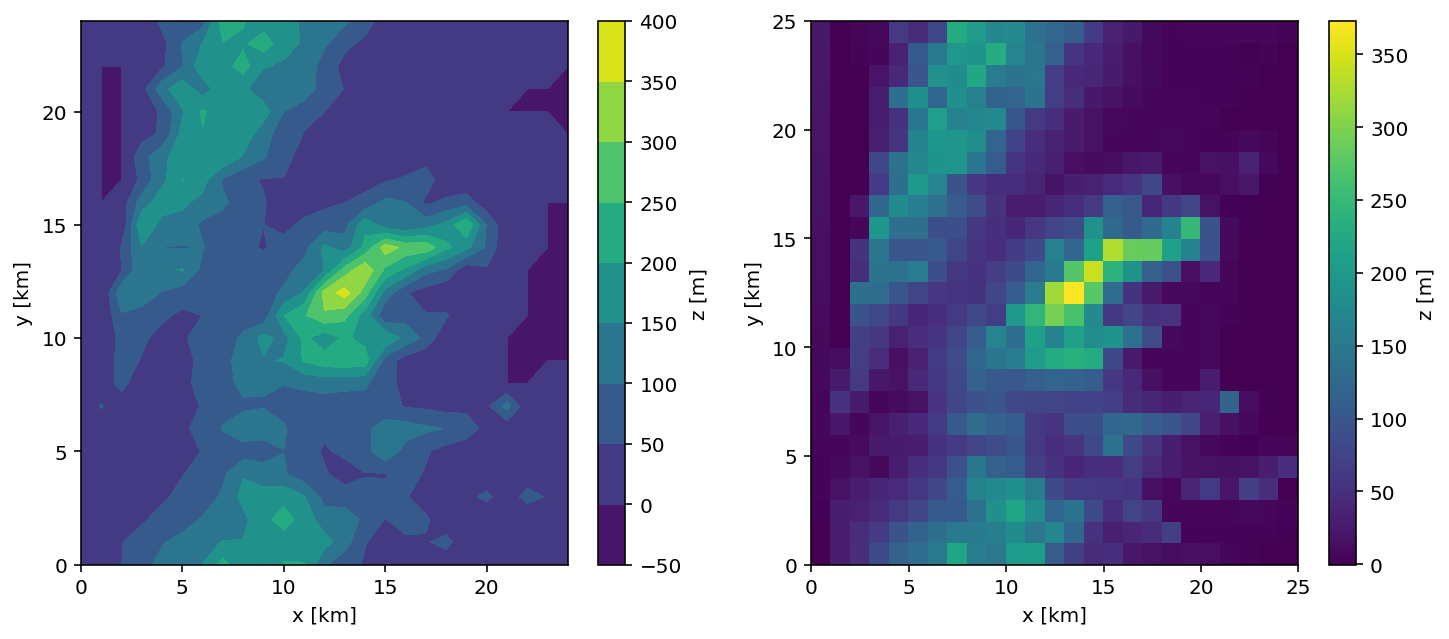

In [3]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
contour = ax[0].contourf(z_data)
mesh = ax[1].pcolormesh(z_data)
for i, plot in enumerate([contour, mesh]):
    fig.colorbar(plot, ax=ax[i], label="z [m]")
    ax[i].set_xlabel("x [km]")
    ax[i].set_ylabel("y [km]")
plt.show()

We clearly see a peak in the center of the domain. However, comparing the height of this peak to the height of the other visible ridges is not trivial: it requires comparing colors from the colorbar. To more quickly compare heights, a 3D representation is much more insightful. Let's plot a 3D surface in `matplotlib`.

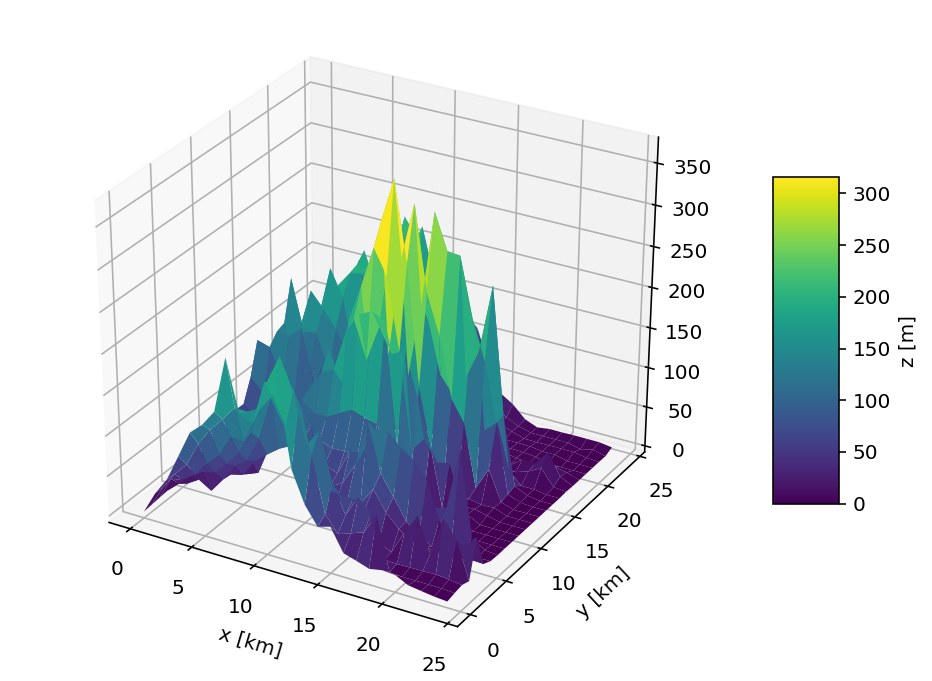

In [4]:
XX, YY = np.meshgrid(np.arange(z_data.shape[0]), np.arange(z_data.shape[1]))
fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection="3d")
surf = ax.plot_surface(XX, YY, z_data, cmap="viridis")
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")
fig.colorbar(surf, shrink=0.5, aspect=5, label="z [m]")
plt.show()

This plot is actually not very insightful. We can see the peak a little better, but at the same time, the coordinates of other local peaks are difficult to discern. We could manually rotate the camera angle, zoom and center position. Hovering over points also gives their exact coordinates, which makes quickly reading out some data from a plot a breeze.

Creating a figure is very easy. We create `Figure` and feed it the data of a `Surface` instance. Then we update its layout with a some display options and labels.

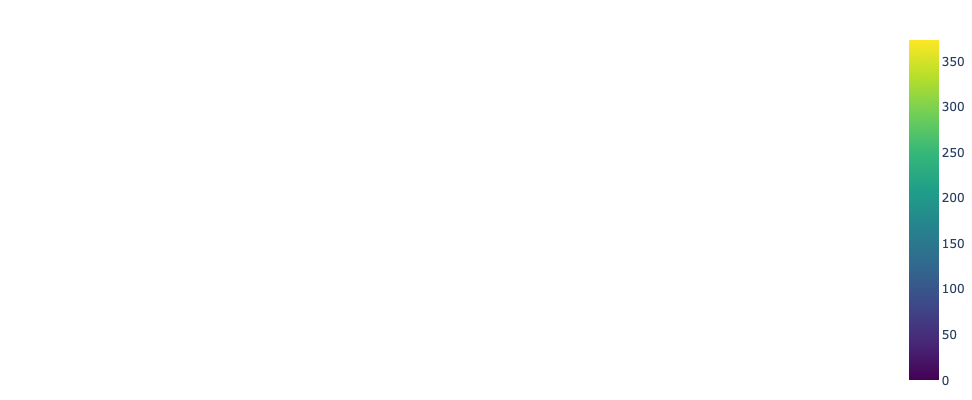

In [45]:
fig = go.Figure(data=[go.Surface(z=z_data.values, colorscale="viridis")])
fig.update_layout(
    autosize=False,
    width=600,
    height=400,
    margin=dict(t=30, r=0, l=20, b=10),
    scene=dict(
        aspectratio=dict(x=1, y=1, z=0.5),
        xaxis=dict(title="x [km]"),
        yaxis=dict(title="y [km]"),
        zaxis=dict(title="z [m]", nticks=4),
    ),
)
fig.show()

We can 'upgrade' this plot through just one line to include contour lines:

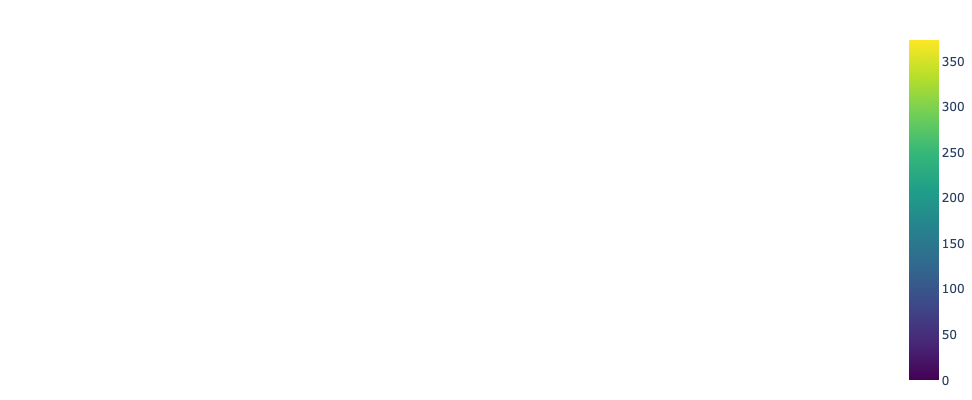

In [44]:
fig = go.Figure(data=[go.Surface(z=z_data.values, colorscale="viridis")])
# Extra line
fig.update_traces(
    contours_z=dict(
        show=True, usecolormap=True, highlightcolor="limegreen", project_z=True
    )
)
fig.update_layout(
    autosize=False,
    width=600,
    height=400,
    margin=dict(t=30, r=0, l=20, b=10),
    scene=dict(
        aspectratio=dict(x=1, y=1, z=0.5),
        xaxis=dict(title="x [km]"),
        yaxis=dict(title="y [km]"),
        zaxis=dict(title="z [m]", nticks=4),
    ),
)
fig.show()

Let's look at another example for which we can use Plotly well: plotting the trajectory of simulated Argo floats, taken from a [Parcels tutorial](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_Argofloats.ipynb). Scroll down until the figures start...

In [72]:
! wget -r --no-parent --cut-dirs=2 -q --reject="index.html*" http://oceanparcels.org/examples-data/GlobCurrent_example_data/;
! mv oceanparcels.org example_data

In [21]:
# Define the new Kernel that mimics Argo vertical movement
def ArgoVerticalMovement(particle, fieldset, time):
    driftdepth = 1000  # maximum depth in m
    maxdepth = 2000  # maximum depth in m
    vertical_speed = 0.10  # sink and rise speed in m/s
    cycletime = 10 * 86400  # total time of cycle in seconds
    drifttime = 9 * 86400  # time of deep drift in seconds

    if particle.cycle_phase == 0:
        # Phase 0: Sinking with vertical_speed until depth is driftdepth
        particle.depth += vertical_speed * particle.dt
        if particle.depth >= driftdepth:
            particle.cycle_phase = 1

    elif particle.cycle_phase == 1:
        # Phase 1: Drifting at depth for drifttime seconds
        particle.drift_age += particle.dt
        if particle.drift_age >= drifttime:
            particle.drift_age = 0  # reset drift_age for next cycle
            particle.cycle_phase = 2

    elif particle.cycle_phase == 2:
        # Phase 2: Sinking further to maxdepth
        particle.depth += vertical_speed * particle.dt
        if particle.depth >= maxdepth:
            particle.cycle_phase = 3

    elif particle.cycle_phase == 3:
        # Phase 3: Rising with vertical_speed until at surface
        particle.depth -= vertical_speed * particle.dt
        # particle.temp = fieldset.temp[time, particle.depth, particle.lat, particle.lon]  # if fieldset has temperature
        if particle.depth <= fieldset.mindepth:
            particle.depth = fieldset.mindepth
            # particle.temp = 0./0.  # reset temperature to NaN at end of sampling cycle
            particle.cycle_phase = 4

    elif particle.cycle_phase == 4:
        # Phase 4: Transmitting at surface until cycletime is reached
        if particle.cycle_age > cycletime:
            particle.cycle_phase = 0
            particle.cycle_age = 0

    particle.cycle_age += particle.dt  # update cycle_age

In [22]:
from parcels import (
    FieldSet,
    ParticleSet,
    JITParticle,
    AdvectionRK4,
    ErrorCode,
    Variable,
)
from datetime import timedelta
import numpy as np

# Load the GlobCurrent data in the Agulhas region from the example_data
filenames = {"U": "example_data/20*.nc", "V": "example_data/20*.nc"}
variables = {
    "U": "eastward_eulerian_current_velocity",
    "V": "northward_eulerian_current_velocity",
}
dimensions = {"lat": "lat", "lon": "lon", "time": "time"}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)
fieldset.mindepth = fieldset.U.depth[0]  # uppermost layer in the hydrodynamic data

# Define a new Particle type including extra Variables
class ArgoParticle(JITParticle):
    # Phase of cycle: init_descend=0, drift=1, profile_descend=2, profile_ascend=3, transmit=4
    cycle_phase = Variable("cycle_phase", dtype=np.int32, initial=0.0)
    cycle_age = Variable("cycle_age", dtype=np.float32, initial=0.0)
    drift_age = Variable("drift_age", dtype=np.float32, initial=0.0)
    # temp = Variable('temp', dtype=np.float32, initial=np.nan)  # if fieldset has temperature


# Initiate one Argo float in the Agulhas Current
pset = ParticleSet(
    fieldset=fieldset, pclass=ArgoParticle, lon=[32], lat=[-31], depth=[0]
)

# combine Argo vertical movement kernel with built-in Advection kernel
kernels = ArgoVerticalMovement + pset.Kernel(AdvectionRK4)

# Create a ParticleFile object to store the output
output_file = pset.ParticleFile(name="argo_float", outputdt=timedelta(minutes=30))

# Now execute the kernels for 30 days, saving data every 30 minutes
pset.execute(
    kernels,
    runtime=timedelta(days=30),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Compiled ArgoParticleArgoVerticalMovementAdvectionRK4 ==> /scratch-local/daanr/parcels-51174/db34f99e1b2811e043439b929bedac10_0.so
INFO: Unable to locate chunking hints from dask, thus estimating the max. chunk size heuristically. Please consider defining the 'chunk-size' for 'array' in your local dask configuration file (see http://oceanparcels.org/faq.html#field_chunking_config and https://docs.dask.org).
INFO: Temporary output files are stored in out-QXKVNBLW.
INFO: You can use "parcels_convert_npydir_to_netcdf out-QXKVNBLW" to convert these to a NetCDF file during the run.
100% (2592000.0 of 2592000.0) |##########| Elapsed Time: 0:00:08 Time:  0:00:08


In [ ]:
# export the trajectory data to a netcdf file and load it
output_file.close()

The output is currently plotted as follows:

In [35]:
nc = netCDF4.Dataset("argo_float.nc")
x = nc.variables["lon"][:].squeeze()
y = nc.variables["lat"][:].squeeze()
z = nc.variables["z"][:].squeeze()
nc.close()

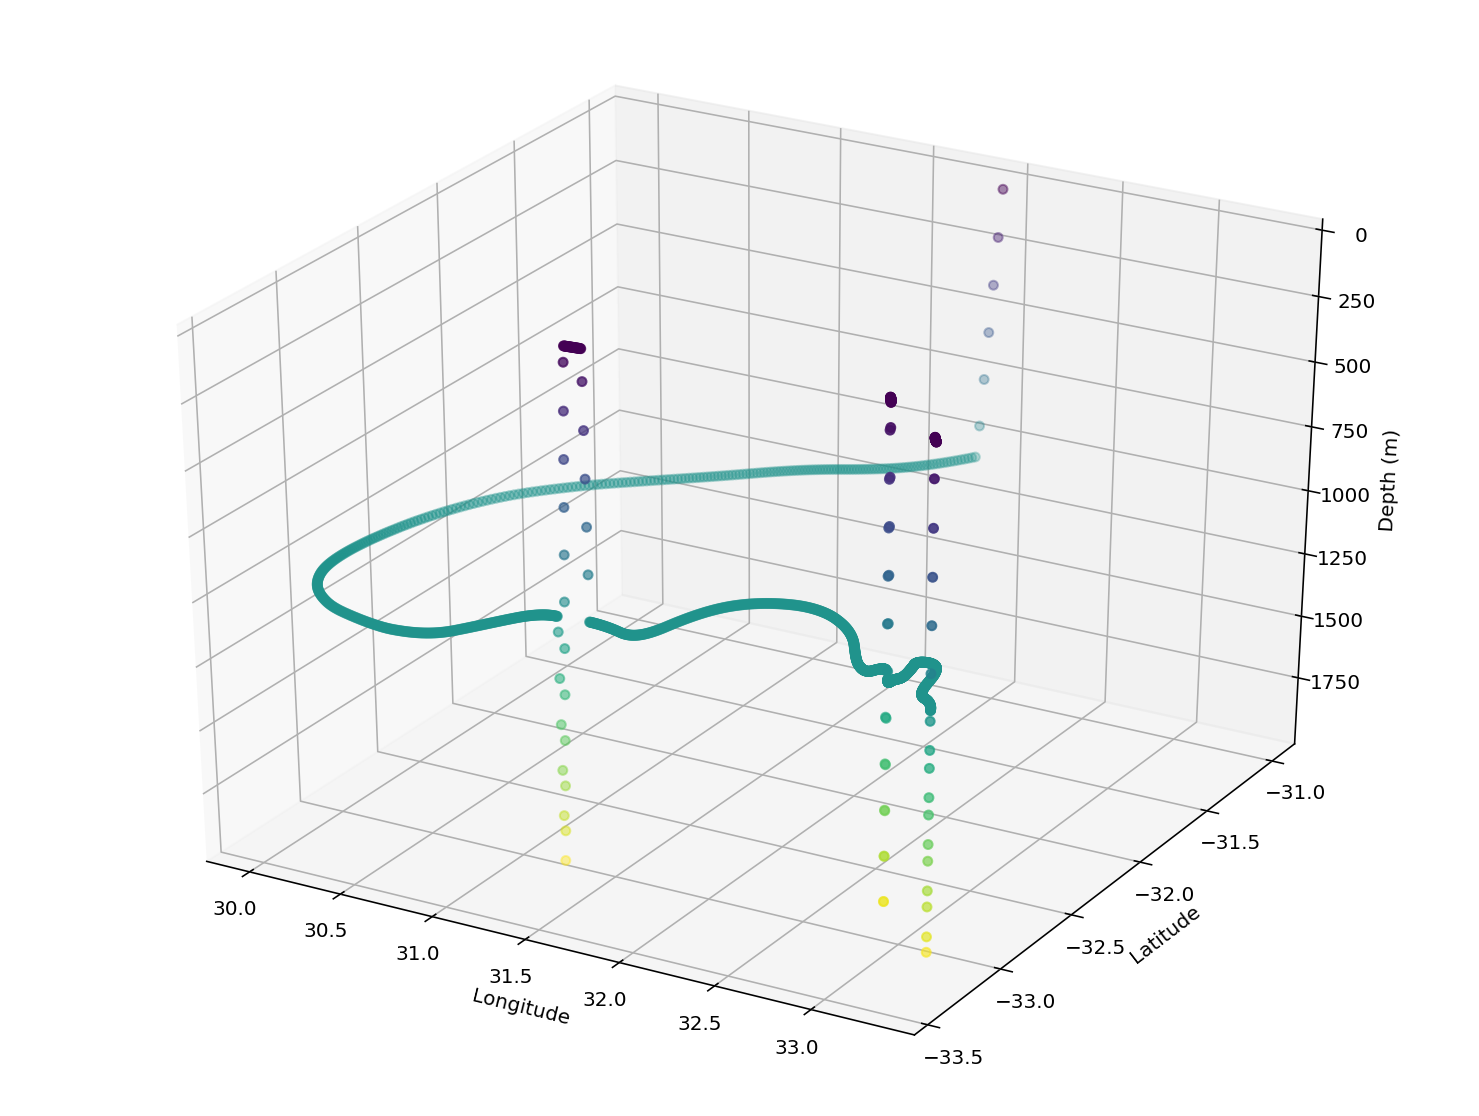

In [36]:
argo_data = xr.open_dataset("argo_float.nc")

fig = plt.figure(figsize=(13, 10))
ax = plt.axes(projection="3d")
cb = ax.scatter(x, y, z, c=z, s=20, marker="o")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
ax.set_zlim(np.max(z), 0)
plt.show()

But in a 3D scatter plot, it's hard to discern the different latitudes, longitudes and depths of each point. Plotly makes viewing the output easier:

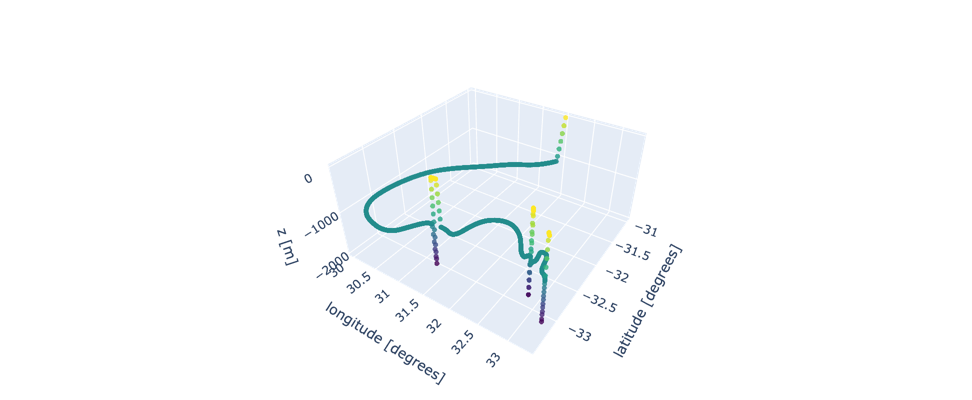

In [43]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=x,
            y=y,
            z=-z,
            mode="markers",
            marker=dict(
                size=3,
                color=-z,  # set color to an array/list of desired values
                colorscale="Viridis",  # choose a colorscale
                opacity=0.8,
            ),
        )
    ]
)
fig.update_xaxes(autorange="reversed")
fig.update_layout(
    autosize=False,
    width=600,
    height=400,
    margin=dict(t=0, r=0, l=20, b=10),
    scene=dict(
        aspectratio=dict(x=1, y=1, z=0.5),
        xaxis=dict(title="longitude [degrees]"),
        yaxis=dict(title="latitude [degrees]"),
        zaxis=dict(title="z [m]", nticks=4),
        camera=dict(eye=dict(x=1, y=-1.5, z=1.25)),
    ),
)
fig.show()

Much better!